In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import itertools
from resources.tokTT import CommentTokenizer as CT
from resources.basicIO import InputOutput as IO
from resources.filterLang import FilterLanguage as FL
from resources.expansion import Expand_U
from resources.fasttext_transformer import classify
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import fasttext
from scipy import spatial
from sklearn import svm
#from sklearn.linear_model import LassoLars
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay


[nltk_data] Downloading package wordnet to C:\Users\AJAY
[nltk_data]     BISWAS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
model_2 = fasttext.load_model("models/ft_unsupervised_N_2.bin")
model_3 = fasttext.load_model("models/ft_unsupervised_N_3.bin")


In [3]:
df_sample = pd.read_csv("datasets/random_sample_data.csv")
# remove unnecessary comments
df_sample = df_sample.drop([x for x in range(len(df_sample)) if int(
    df_sample['label'][x]) != 0 and int(df_sample['label'][x]) != 1])

df_sample['label'].value_counts()


0    1847
1    1407
Name: label, dtype: int64

In [4]:
X_raw = df_sample['tokenized_comment']
y = df_sample['label']

X_2 = [model_2[x] for x in X_raw]
X_3 = [model_3[x] for x in X_raw]


In [5]:
# modify here to change models
X = X_2
model = model_2
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.2,
                                                    random_state=37,
                                                    stratify=y)
print(len(X_train))
print(len(X_test))
print(y_train.value_counts())
print(y_test.value_counts())

2603
651
0    1477
1    1126
Name: label, dtype: int64
0    370
1    281
Name: label, dtype: int64


In [6]:
N_SAMPLES = 1000

classifiers = {
    "SVM": make_pipeline(StandardScaler(), svm.SVC(probability=True, kernel='rbf')),
    "KNN": KNeighborsClassifier(n_neighbors=19),
    "LR": make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', penalty='l2', C=0.05, max_iter=10000, random_state=2)),
    "MLP": make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000, activation='logistic'))
}


In [7]:
classifier_names = ['LR', 'SVM', 'KNN', 'MLP']

In [8]:
X_seed, X_expand, y_seed, y_expand = train_test_split(X_train,
                                                      y_train, test_size=0.99,
                                                      random_state=40,
                                                      stratify=y_train)


### Compare uncertain selection criterias

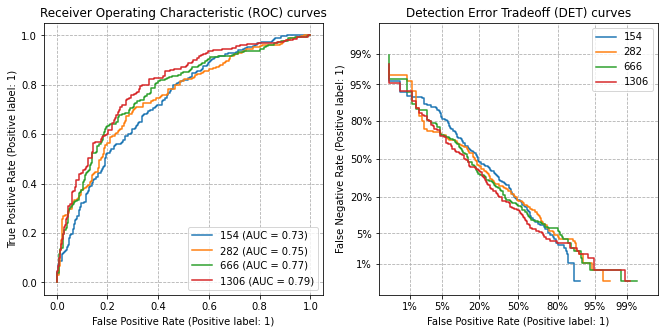

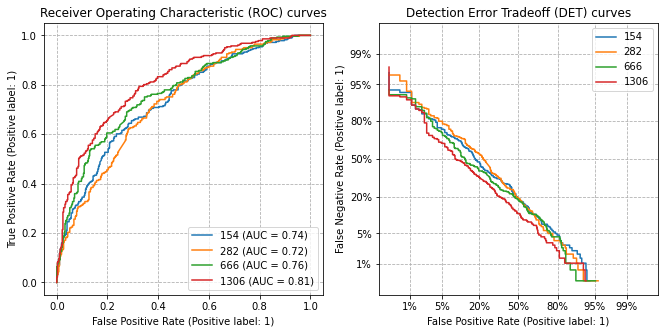

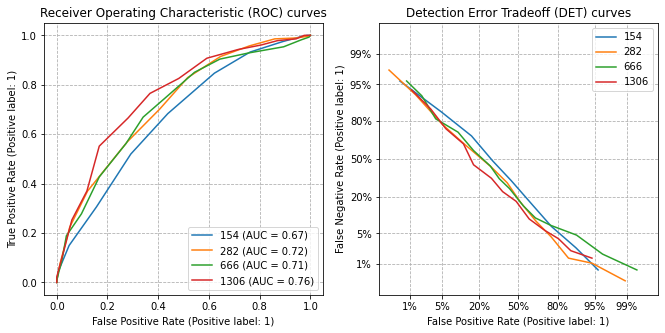

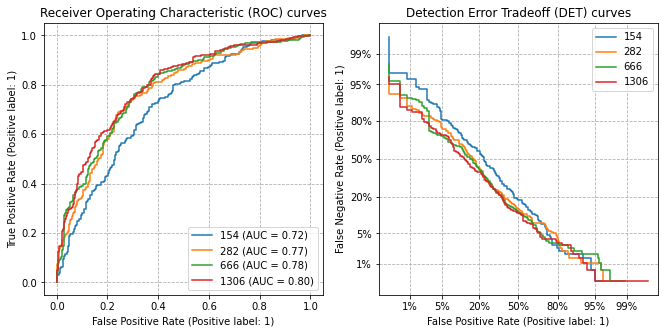

In [9]:
best_select = [1,2,5,10]

for c in classifier_names:

    X_u = []
    y_u = []

    for i in best_select:
        X_uncertain_exp_u, y_uncertain_exp_u, X_certain_exp_u, y_certain_exp_u = Expand_U(model,
                                                                                        classifiers[c],
                                                                                        list(
                                                                                            X_seed),
                                                                                        list(
                                                                                            y_seed),
                                                                                        list(
                                                                                            X_expand),
                                                                                        list(
                                                                                            y_expand),
                                                                                        20,
                                                                                        i
                                                                                        )
        X_u.append(X_uncertain_exp_u)
        y_u.append(y_uncertain_exp_u)

    # prepare plots
    fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))
    clf = classifiers[c]

    for i in range(len(X_u)):
        clf.fit(X_u[i], y_u[i])

        RocCurveDisplay.from_estimator(
            clf, X_test, y_test, ax=ax_roc, name=str(len(X_u[i])))
        DetCurveDisplay.from_estimator(
            clf, X_test, y_test, ax=ax_det, name=str(len(X_u[i])))

    ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
    ax_det.set_title("Detection Error Tradeoff (DET) curves")

    ax_roc.grid(linestyle="--")
    ax_det.grid(linestyle="--")

    plt.legend()
    plt.savefig('outputs/figures/' + 'ROC_DET_u' + c,
                dpi=300, bbox_inches='tight')
    plt.show()


In [10]:
len(X_expand)

2577